In [54]:
import optuna
import optuna.visualization as vis
import time

import scipy.stats as st

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier


from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, make_scorer,classification_report


import yaml

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [3]:
config

{'data': {'raw': {'file_raw': '../data/raw/healthcare-dataset-stroke-data.csv'},
  'clean': {'file_clean': '../data/clean/clean.csv'}}}

In [55]:
df = pd.read_csv(config["data"]["raw"]["file_raw"])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [56]:
df["bmi"] = df["bmi"].fillna(df["bmi"].mean())
df = df[df["gender"] != "Other"]

In [57]:
df["work_type"].value_counts(), df["smoking_status"].value_counts()

(work_type
 Private          2924
 Self-employed     819
 children          687
 Govt_job          657
 Never_worked       22
 Name: count, dtype: int64,
 smoking_status
 never smoked       1892
 Unknown            1544
 formerly smoked     884
 smokes              789
 Name: count, dtype: int64)

In [58]:
df["work_type"] = df["work_type"].map({"Private": 4, "Self-employed": 3, "Govt_job": 2, "children": 1, "Never_worked": 0})
df["smoking_status"] = df["smoking_status"].map({"smokes": 3, "Unknown": 2, "formerly smoked": 1, "never smoked": 0})
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,4,Urban,228.69,36.600000,1,1
1,51676,Female,61.0,0,0,Yes,3,Rural,202.21,28.893237,0,1
2,31112,Male,80.0,0,1,Yes,4,Rural,105.92,32.500000,0,1
3,60182,Female,49.0,0,0,Yes,4,Urban,171.23,34.400000,3,1
4,1665,Female,79.0,1,0,Yes,3,Rural,174.12,24.000000,0,1


In [59]:
features = df.drop(columns= "stroke")
target = df["stroke"]

In [60]:
df_num = df.select_dtypes(include="number").drop("id",axis = 1)
df_num.head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,67.0,0,1,4,228.69,36.600000,1,1
1,61.0,0,0,3,202.21,28.893237,0,1
2,80.0,0,1,4,105.92,32.500000,0,1
3,49.0,0,0,4,171.23,34.400000,3,1
4,79.0,1,0,3,174.12,24.000000,0,1


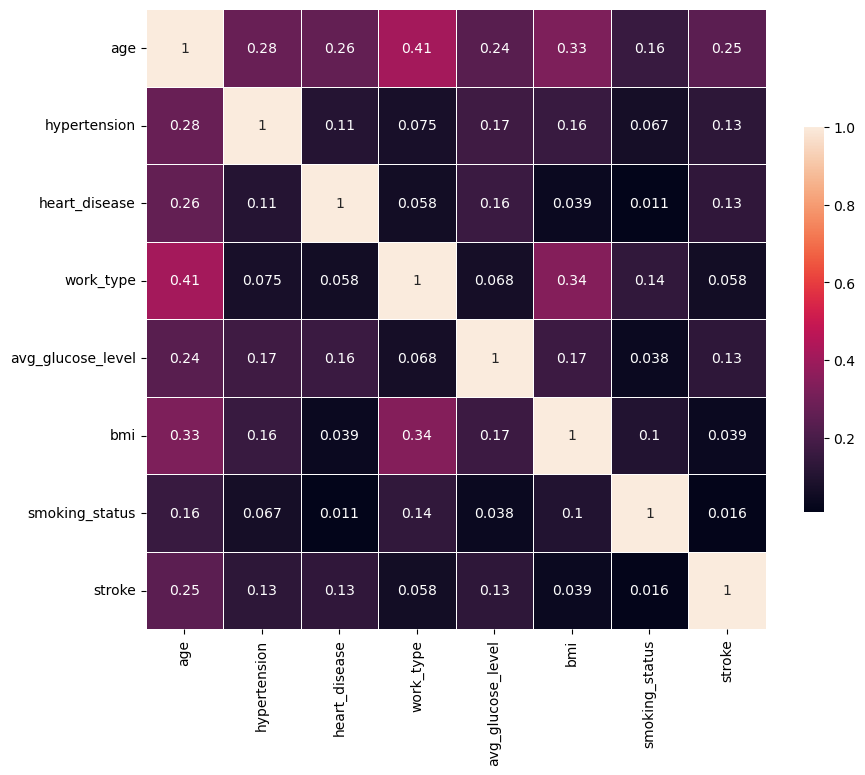

In [10]:
# corr=df_num.corr()
corr=np.abs(df_num.corr())

#Set up mask for triangle representation
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
# sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [13]:
X_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1547,41424,Male,59.0,0,1,Yes,3,Rural,194.98,30.4,2
4976,63656,Female,18.0,0,0,No,4,Urban,101.95,46.0,1
246,27153,Female,75.0,0,0,Yes,3,Rural,78.80,29.3,1
2824,15539,Female,41.0,0,0,Yes,4,Rural,97.41,25.5,0
3799,2029,Female,40.0,0,0,Yes,4,Rural,92.35,38.0,0


In [21]:
y_train.head()

1547    0
4976    0
246     1
2824    0
3799    0
Name: stroke, dtype: int64

In [62]:
X_train_num = X_train.select_dtypes(include="number").drop("id",axis = 1)
X_test_num = X_test.select_dtypes(include="number").drop("id",axis = 1)

In [63]:
normalizer = MinMaxScaler()
normalizer.fit(X_train_num)
X_train_num_trans = normalizer.transform(X_train_num)
X_test_num_trans = normalizer.transform(X_test_num)

In [64]:
X_train_num_norm = pd.DataFrame(X_train_num_trans, columns=X_train_num.columns, index=X_train_num.index )
X_train_num_norm.head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status
1547,0.719238,0.0,1.0,0.75,0.645647,0.230241,0.666667
4976,0.218750,0.0,0.0,1.00,0.216185,0.408935,0.333333
246,0.914551,0.0,0.0,0.75,0.109316,0.217640,0.333333
2824,0.499512,0.0,0.0,1.00,0.195227,0.174112,0.000000
3799,0.487305,0.0,0.0,1.00,0.171868,0.317297,0.000000


In [65]:
X_test_num_norm = pd.DataFrame(X_test_num_trans, columns=X_test_num.columns, index=X_test_num.index )
X_test_num_norm.head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status
42,1.000000,0.0,1.0,1.00,0.414458,0.184422,1.000000
380,0.047852,0.0,0.0,0.25,0.235897,0.073310,0.666667
1559,0.645996,0.0,0.0,1.00,0.080833,0.647194,0.666667
352,0.243164,0.0,0.0,1.00,0.191349,0.272623,0.000000
3639,0.621582,1.0,0.0,1.00,0.141815,0.246277,0.000000


In [66]:
ohe = OneHotEncoder(sparse_output=False)

ohe.fit(X_train[['gender', 'ever_married', 'Residence_type']])
X_train_obj_trans = ohe.transform(X_train[['gender', 'ever_married',  'Residence_type']])
X_test_obj_trans = ohe.transform(X_test[['gender', 'ever_married', 'Residence_type']])

In [67]:
X_train_obj_trans,X_test_obj_trans

(array([[0., 1., 0., 1., 1., 0.],
        [1., 0., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0.],
        ...,
        [0., 1., 0., 1., 1., 0.],
        [0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0.]]),
 array([[0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 1., 0.],
        [1., 0., 0., 1., 1., 0.],
        ...,
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0.]]))

In [68]:
X_train_obj_ohe = pd.DataFrame(X_train_obj_trans, columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_obj_ohe = pd.DataFrame(X_test_obj_trans, columns=ohe.get_feature_names_out(), index=X_test.index)

X_train_obj_ohe.head()


,gender_Female,gender_Male,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban
1547,0.0,1.0,0.0,1.0,1.0,0.0
4976,1.0,0.0,1.0,0.0,0.0,1.0
246,1.0,0.0,0.0,1.0,1.0,0.0
2824,1.0,0.0,0.0,1.0,1.0,0.0
3799,1.0,0.0,0.0,1.0,1.0,0.0


In [69]:
X_train_trans = pd.concat([X_train_num_norm, X_train_obj_ohe], axis=1)
X_test_trans = pd.concat([X_test_num_norm, X_test_obj_ohe], axis=1)

In [70]:
target.value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

-> Imbalanced target

# 1.KNN model

Using KNeighborsClassifier because the predicted "stroke" column is categorical
For classification we focus on precision,recall

Train KNN for imbalanced data in target

In [87]:
X_train_trans

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban
1547,0.719238,0.0,1.0,0.75,0.645647,0.230241,0.666667,0.0,1.0,0.0,1.0,1.0,0.0
4976,0.218750,0.0,0.0,1.00,0.216185,0.408935,0.333333,1.0,0.0,1.0,0.0,0.0,1.0
246,0.914551,0.0,0.0,0.75,0.109316,0.217640,0.333333,1.0,0.0,0.0,1.0,1.0,0.0
2824,0.499512,0.0,0.0,1.00,0.195227,0.174112,0.000000,1.0,0.0,0.0,1.0,1.0,0.0
3799,0.487305,0.0,0.0,1.00,0.171868,0.317297,0.000000,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4932,0.340820,1.0,0.0,1.00,0.145370,0.324170,1.000000,0.0,1.0,1.0,0.0,0.0,1.0
3265,0.743652,0.0,0.0,0.75,0.123904,0.224513,0.000000,0.0,1.0,0.0,1.0,1.0,0.0
1653,0.536133,0.0,0.0,1.00,0.182762,0.207331,1.000000,0.0,1.0,0.0,1.0,1.0,0.0
2607,0.255371,0.0,0.0,1.00,0.303850,0.222222,0.333333,0.0,1.0,1.0,0.0,0.0,1.0


In [71]:
knn = KNeighborsClassifier()
knn.fit(X_train_trans, y_train)
y_test_knn_pred = knn.predict(X_test_trans)

accuracy_test_knn = knn.score(X_test_trans, y_test)
print(classification_report(y_pred = y_test_knn_pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       968
           1       0.14      0.02      0.03        54

    accuracy                           0.94      1022
   macro avg       0.55      0.51      0.50      1022
weighted avg       0.91      0.94      0.92      1022



In [72]:
# print(f"The accuracy of the model with trained and imbalanced data is {accuracy_train_knn: .2f}")
print(f"The accuracy of the model with Classification for imbalanced data is {accuracy_test_knn: .2f}")

The accuracy of the model with Classification for imbalanced data is  0.94


### Hyperparam tuning before Oversampling

In [73]:
import tuning_func as tuneFunc

In [89]:
confidence_level = 0.95
folds = 10

start_time = time.time()
study = optuna.create_study(direction="minimize") # We want to have the maximum values for the R2 scores
study.optimize(lambda trial: tuneFunc.objective(trial, confidence_level, folds, X_train=X_train_trans, y_train=y_train), n_trials=45)#  objective(trial, confidence_level, folds), n_trials=45)
end_time = time.time()

print("\n")
print(f"Time taken to find the best combination of hyperparameters among the given ones: {end_time - start_time: .4f} seconds")
print("\n")
print("The best combination of hyperparameters found was: ", study.best_params)
print(f"The best R2 found was: {study.best_value: .4f}")

[I 2025-08-01 10:56:16,685] A new study created in memory with name: no-name-0f11ae8e-19a5-436b-b510-76550f6d2e9b


[I 2025-08-01 10:56:17,814] Trial 0 finished with value: 0.21513799665070868 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.21513799665070868.
[I 2025-08-01 10:56:21,950] Trial 1 finished with value: 0.21603117604153965 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 3}. Best is trial 0 with value: 0.21513799665070868.
[I 2025-08-01 10:56:23,146] Trial 2 finished with value: 0.21692066528717024 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.21513799665070868.
[I 2025-08-01 10:56:24,568] Trial 3 finished with value: 0.21242850208590633 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.21242850208590633.
[I 2025-08-01 10:56:26,750] Trial 4 finished with value: 0.21608979325719938 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.21242850208590633.
[I 2025-08-01 10:56:27,662] Tria



Time taken to find the best combination of hyperparameters among the given ones:  90.2855 seconds


The best combination of hyperparameters found was:  {'n_neighbors': 24, 'weights': 'uniform', 'p': 1}
The best R2 found was:  0.2088


In [90]:
results = sorted([(index,
  trial.user_attrs['CV_score_summary'][0],
  trial.user_attrs['CV_score_summary'][1],
  trial.user_attrs['CV_score_summary'][2]) for index, trial in enumerate(study.trials)], key=lambda x: x[2], reverse=True)

print(f"The R2 confidence interval for the best combination of hyper parameters is: {results[0][1:]}")

The R2 confidence interval for the best combination of hyper parameters is: (np.float64(0.2372), np.float64(0.2471), np.float64(0.257))


In [91]:
#Classification
best_model = KNeighborsClassifier(**study.best_params)
best_model.fit(X_train_trans, y_train)

y_test_knn_pred = knn.predict(X_test_trans)

accuracy_test_knn = knn.score(X_test_trans, y_test)
print(classification_report(y_pred = y_test_knn_pred, y_true = y_test))

# # Only of Regression
# best_model = KNeighborsRegressor(**study.best_params)
# y_pred_test_df = best_model.predict(X_test_num_norm)
# print(f"Test MAE: {mean_absolute_error(y_pred_test_df, y_test): .3f}")
# print(f"Test MSE: {mean_squared_error(y_pred_test_df, y_test): .3f}")
# print(f"Test RMSE: {root_mean_squared_error(y_pred_test_df, y_test): .3f}")
# print(f"Test R2 score:  {best_model.score(X_test_num_norm, y_test): .3f}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Residence_type_Rural
- Residence_type_Urban
- ever_married_No
- ever_married_Yes
- gender_Female
- ...


## Oversampling

In [78]:
train = pd.DataFrame(X_train_num_trans, columns=X_train_num.columns, index=X_train_num.index)
train["stroke"] = y_train.values

In [79]:
stroked = train[train["stroke"] == 1]
no_stroked = train[train["stroke"] == 0]

In [80]:
len(stroked),len(no_stroked)

(195, 3892)

In [81]:
yes_oversampled = resample(stroked,
                                    replace=True,
                                    n_samples = len(no_stroked),
                                    random_state=0)

In [35]:
train_over = pd.concat([yes_oversampled, no_stroked])
train_over

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
93,0.975586,1.0,0.0,0.75,0.062044,0.182131,0.666667,1
200,0.902344,0.0,0.0,1.00,0.517081,0.212981,0.666667,1
102,0.902344,0.0,0.0,1.00,0.814745,0.278351,0.333333,1
201,0.975586,1.0,1.0,1.00,0.554750,0.242841,0.333333,1
40,0.951172,0.0,0.0,1.00,0.105761,0.155785,0.333333,1
...,...,...,...,...,...,...,...,...
4932,0.340820,1.0,0.0,1.00,0.145370,0.324170,1.000000,0
3265,0.743652,0.0,0.0,0.75,0.123904,0.224513,0.000000,0
1653,0.536133,0.0,0.0,1.00,0.182762,0.207331,1.000000,0
2607,0.255371,0.0,0.0,1.00,0.303850,0.222222,0.333333,0


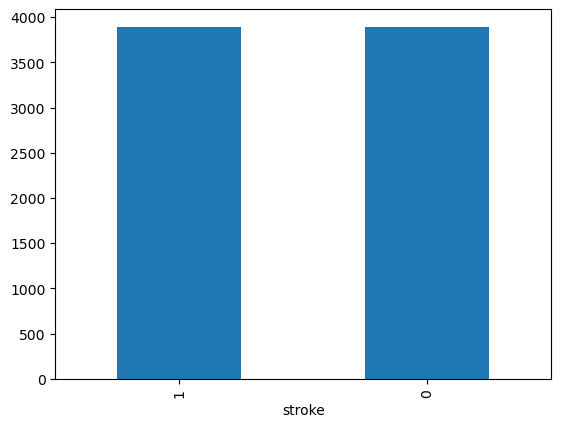

In [82]:
stroked_plt = train_over["stroke"].value_counts()
stroked_plt.plot(kind="bar")
plt.show()

#### Now, with balanced data, we will create a new instance of KNN


In [83]:
X_train_over = train_over.drop(columns = ["stroke"])
y_train_over = train_over["stroke"]

In [86]:
knn = KNeighborsClassifier()
knn.fit(X_train_over, y_train_over)

# y_train_knn_pred = knn.predict(X_train_over)
# accuracy_train_knn = knn.score(X_train_over, y_train_over)

y_test_knn_pred = knn.predict(X_test_trans)

accuracy_test_knn = knn.score(X_test_trans, y_test)
print(classification_report(y_pred = y_test_knn_pred, y_true = y_test))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Residence_type_Rural
- Residence_type_Urban
- ever_married_No
- ever_married_Yes
- gender_Female
- ...


In [47]:
# print(f"The accuracy of the model with trained and balanced data is {accuracy_train_knn: .2f}")
print(f"The accuracy of the model with Classification for balanced data is {accuracy_test_knn: .2f}")

The accuracy of the model with Classification for balanced data is  0.86


### Hyperparam tuning after balanced

In [48]:
confidence_level = 0.95
folds = 10 # min 2, max- number of samples in train set (best number of folds 5 or 10)

start_time = time.time()
study = optuna.create_study(direction="minimize") # We want to have the maximum values for the R2 scores
study.optimize(lambda trial: tuneFunc.objective(trial, confidence_level, folds, X_train=X_train_over, y_train=y_train_over), n_trials=45)#  objective(trial, confidence_level, folds), n_trials=45)
end_time = time.time()

print("\n")
print(f"Time taken to find the best combination of hyperparameters among the given ones: {end_time - start_time: .4f} seconds")
print("\n")
print("The best combination of hyperparameters found was: ", study.best_params)
print(f"The best R2 found was: {study.best_value: .4f}")

[I 2025-08-01 09:27:29,504] A new study created in memory with name: no-name-7b965bc9-7f1f-4859-9f5a-b02f28873d27
[I 2025-08-01 09:27:30,388] Trial 0 finished with value: 0.23180454365017286 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.23180454365017286.
[I 2025-08-01 09:27:30,960] Trial 1 finished with value: 0.25755983719190256 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.23180454365017286.
[I 2025-08-01 09:27:34,119] Trial 2 finished with value: 0.2266585364411015 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 3}. Best is trial 2 with value: 0.2266585364411015.
[I 2025-08-01 09:27:34,717] Trial 3 finished with value: 0.19155851254676487 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.19155851254676487.
[I 2025-08-01 09:27:38,530] Trial 4 finished with value: 0.3704227477610541 and parameters: {'n_neighbors': 25, 'w



Time taken to find the best combination of hyperparameters among the given ones:  71.6643 seconds


The best combination of hyperparameters found was:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
The best R2 found was:  0.1278


In [52]:
results = sorted([(index,
  trial.user_attrs['CV_score_summary'][0],
  trial.user_attrs['CV_score_summary'][1],
  trial.user_attrs['CV_score_summary'][2]) for index, trial in enumerate(study.trials)], key=lambda x: x[2], reverse=True)

print(f"The R2 confidence interval for the best combination of hyper parameters after Over sampling is: {results[0][1:]}")

The R2 confidence interval for the best combination of hyper parameters after Over sampling is: (np.float64(0.2906), np.float64(0.3704), np.float64(0.4502))


In [53]:
best_model = KNeighborsClassifier(**study.best_params)
best_model.fit(X_train_over, y_train_over)
y_pred_test_df = best_model.predict(X_test_num_norm)

print(f"Test MAE: {mean_absolute_error(y_pred_test_df, y_test): .3f}")
print(f"Test MSE: {mean_squared_error(y_pred_test_df, y_test): .3f}")
print(f"Test RMSE: {root_mean_squared_error(y_pred_test_df, y_test): .3f}")
print(f"Test R2 score:  {best_model.score(X_test_num_norm, y_test): .3f}")

Test MAE:  0.076
Test MSE:  0.076
Test RMSE:  0.276
Test R2 score:   0.924
